<a href="https://colab.research.google.com/github/davidsonsantana89/RNA-e-Deep-Learning---CESAR-School-2023.02/blob/main/Atividade%20Aula%204.2/dass_4_2_Iris_dataset_2_ou_mais_camadas_fronteira_dinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DAVIDSON ALVES SANTOS DE SANTANA

dass@cesar.school

# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [9]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

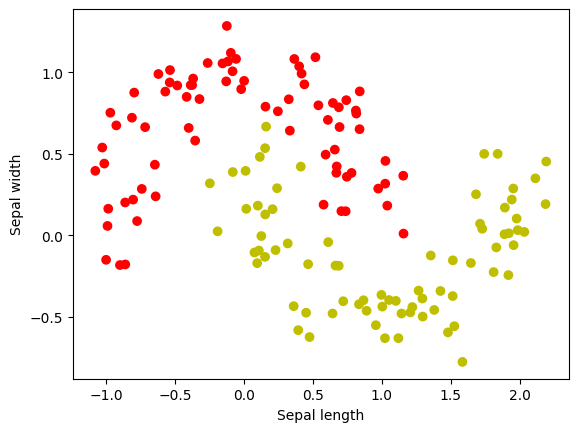

In [10]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [11]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [19]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [20]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

In [21]:
predict(model, X_tensor)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Classe para visualização dinâmica

In [22]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [23]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2511)


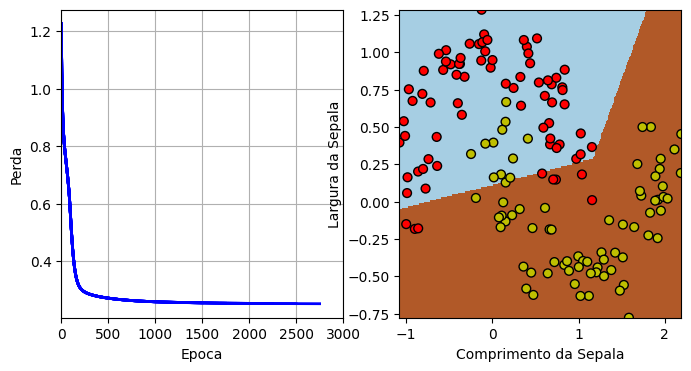

In [24]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [25]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.3202, -0.4579],
        [-0.0277,  1.0160],
        [ 0.2853, -0.3040],
        [ 1.2730, -0.0386],
        [ 0.0488, -0.1083]])
dense.0.bias    torch.Size([5])
tensor([ 0.6879,  0.9268,  0.5070, -1.4786, -0.3132])
dense.2.weight  torch.Size([5, 5])
tensor([[-0.0446, -0.3055,  0.0353, -0.2757,  0.2126],
        [-0.2825,  0.7125,  0.0921, -1.1604, -0.2159],
        [-0.1027,  0.4374,  0.1923, -0.1108, -0.2239],
        [-0.3155, -0.2580, -0.2689, -0.2664, -0.0411],
        [-0.4310,  1.1091, -0.2522, -1.6305,  0.2784]])
dense.2.bias    torch.Size([5])
tensor([-0.4471,  0.2356, -0.1490, -0.4238,  0.7320])
dense.4.weight  torch.Size([3, 5])
tensor([[ 0.1081,  1.2515,  0.2229, -0.3963,  1.8379],
        [ 0.0974, -0.4654,  0.1577,  0.2984, -0.6987],
        [ 0.3541, -0.2067, -0.0781, -0.2847, -0.6113]])
dense.4.bias    torch.Size([3])
tensor([-1.4014,  3.8511, -2.9373])


### Avaliação do classificador

In [26]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8733333333333333


### Matriz de confusão

In [27]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,67,11
1,8,64


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.


Final loss: tensor(0.0073)

Training Accuracy:  1.0


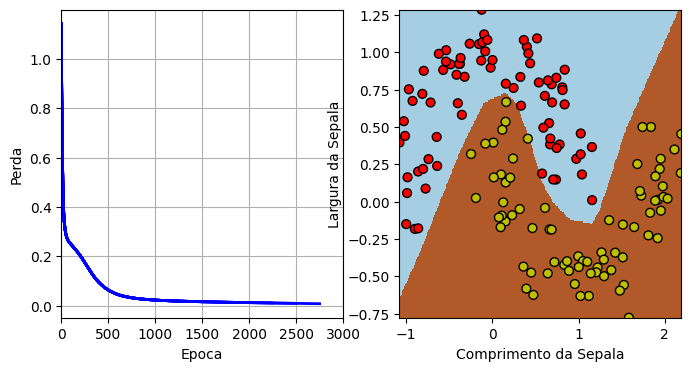

In [33]:
# situação 1: aumento do número de neurônios

# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

Final loss: tensor(0.2495)

Training Accuracy:  0.8733333333333333


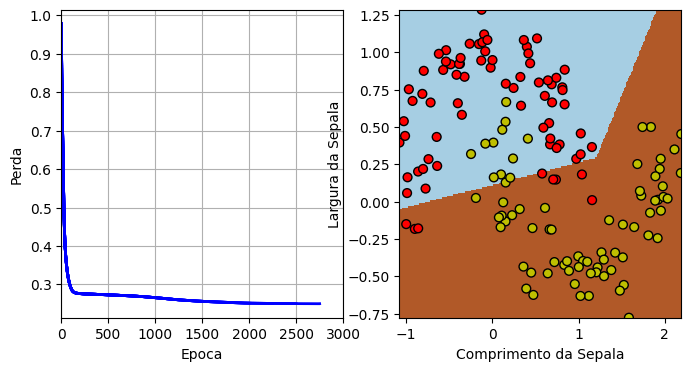

In [35]:
# situação 2: diminuição do número de neurônios

# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

Final loss: tensor(0.0037)

Training Accuracy:  1.0


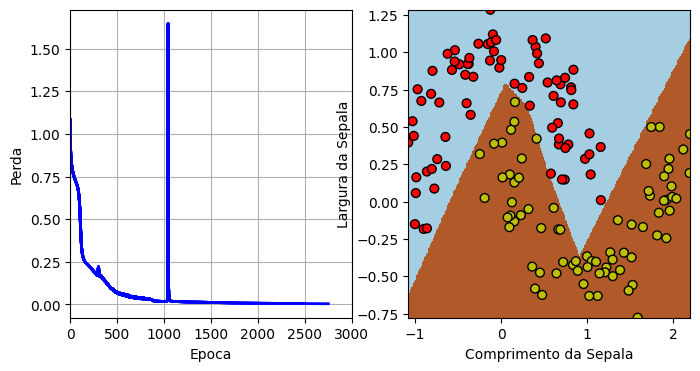

In [36]:
# situação 3: diminuição do número de camadas

# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

Final loss: tensor(0.2733)

Training Accuracy:  0.8666666666666667


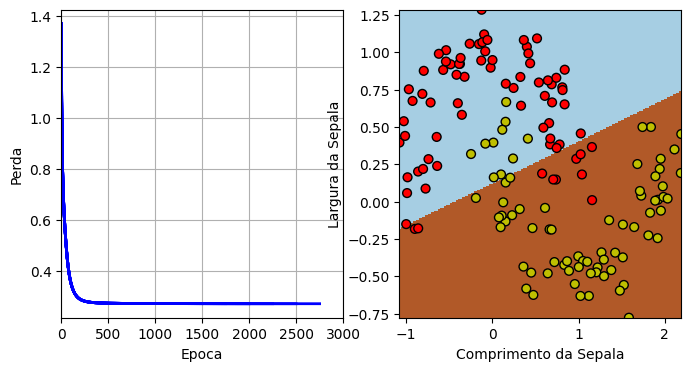

In [38]:
# situação 4: diminuição do número de camadas

# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

Final loss: tensor(0.0185)

Training Accuracy:  0.9933333333333333


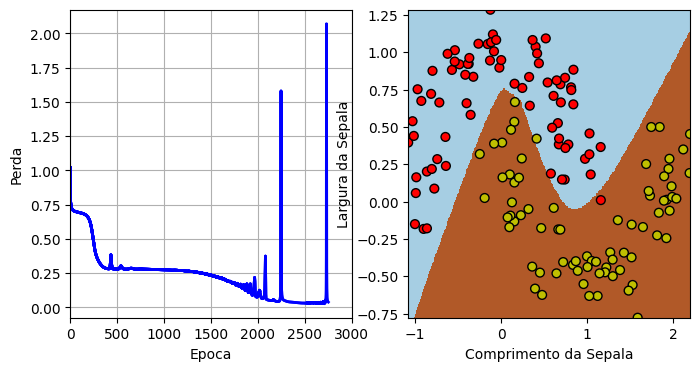

In [57]:
# situação 5: Combinação de ReLU com Sigmoid

# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 24),
            nn.Sigmoid(),
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 24),
            nn.Sigmoid(),
            nn.Linear(24, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

### CONCLUSÕES

* Aumentando-se o números de neurônios ou o de camadas, a acurácia melhora consideramente, principalmente quando aumenta-se o número de camadas.

* Diminuindo-se o números de neurônios ou o de camadas, a acurácia tem seu valor reduzido.

* A clusterização e a acurácia melhoram com a combinação de ReLU com Sigmoid. De modo particular, na clusterização percebe-se que a separação é feita de modo suave, com pouca presença perceptível de traços retos.

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.


Final loss: tensor(0.2739)

Training Accuracy:  0.8666666666666667


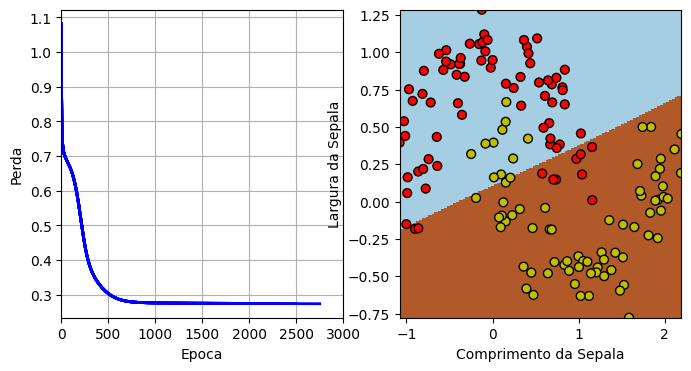

In [41]:
# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 25),
            nn.Sigmoid(),
            nn.Linear(25, 25),
            nn.Sigmoid(),
            nn.Linear(25,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

### CONCLUSÕES

Ao substituir-se a ReLU pela Sigmoid há uma queda no valor da acurárcia. Observando-se o gráfico de clusterização percebe-se que a Sigmoid busca traçar retas para fazer tal clusterização, sendo que os dados não são lineares.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Final loss: tensor(0.2732)

Training Accuracy:  0.8666666666666667


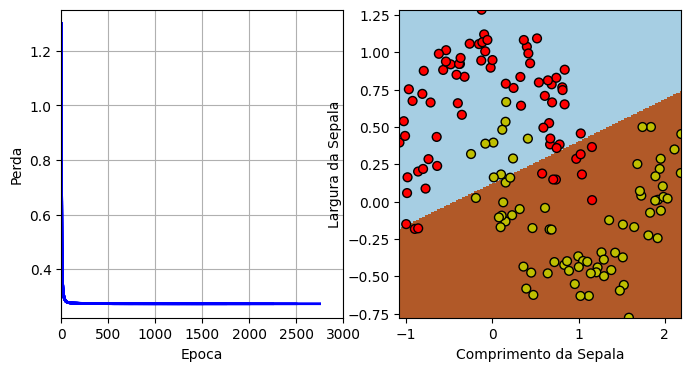

In [59]:
# construindo o modelo de rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 25),
            nn.Linear(25, 25),
            nn.Linear(25,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

# função de predição
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

# parâmetros de treinamento
lr = 0.15
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# laço principal de treinamento
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# avaliação do classificador
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)

### CONCLUSÕES

* Não utilizar-se ativação linear faz com que o modelo não consiga resolver o problema de maneira satisfatória, pois ele vai traçar a uma única reta para fazer a separação dos dados.

## Principais aprendizados